## Compare our sustainability score to Newsweek's rankings

Objective
Once you obtain all the inference results, it could be helpful to analyze the correlation between the company scores
generated by your method and an external ranking

- Mark which companies we are using in our analysis.
- Find correlation between our score and the scores here.



Source
https://www.newsweek.com/rankings/americas-most-responsible-companies-2024

In [1]:
import pandas as pd
from fuzzywuzzy import fuzz

### Read Newsweek's rankings

In [163]:
nwdf = pd.read_csv('newsweek_responsibility_ranks.csv', index_col=None)

In [164]:
nwdf.head(20)

,Rank,Company,HQ City,HQ State,Industry,Rank in Industry,Score Overall,Score Environmental Concerns,Score Social Concerns,Score Corporate Governance Concerns
0,1,Merck & Co,Rahway,New Jersey,Health Care & Life Sciences,1,91.98,91.41,84.61,100.00
1,2,Xylem,Washington,District of Columbia,Capital Goods,1,91.27,95.42,88.88,89.61
2,3,HP,Palo Alto,California,Technology Hardware,1,90.29,98.89,90.07,82.01
3,4,Cisco Systems,San Jose,California,Technology Hardware,2,90.03,98.60,84.15,87.46
4,5,Hewlett Packard Enterprise,Spring,Texas,Technology Hardware,3,88.37,94.55,81.48,89.16
5,6,Regency Centers,Jacksonville,Florida,Real Estate & Housing,1,88.22,86.69,90.53,87.52
6,7,Applied Materials,Santa Clara,California,Technology Hardware,4,88.13,95.19,87.32,81.98
7,8,Hasbro,Pawtucket,Rhode Island,Consumer Goods,1,88.03,94.03,89.99,80.17
8,9,Illumina,San Diego,California,Health Care & Life Sciences,2,87.74,92.86,97.91,72.54
9,*,Mastercard,Purchase,New York,Financial,*,87.65,98.39,75.02,89.63


---

### Read companies we are analyzing

In [165]:
odf = pd.read_csv('../report_prediction/final_scores.csv', index_col=None)

- Manually add company names

In [166]:
# for c in nwdf['Company'][400:]:
#     print(c)

In [167]:
names = [
    'Tesla', 'United Parcel Service', 'Salesforce', 'Adobe', 'Pepsi', 'Schwab', 'Progressive', 'SAP', 'Bank of America', 'Procter & Gamble', 'BlackRock', 'Novo Nordisk', 'Comcast', 'Wells Fargo', 'Intuit', 'Berkshire Hills Bancorp', 'Oracle', 'Union Pacific', 'Danaher', 'Blackstone', 'Exxon Mobil', 'Abbvie',
    'Royal Bank of Canada', 'Amgen', 'S&P Global', 'Visa', 'AT&T', 'HDFC Bank', 'Walt Disney', 'JPMorgan Chase', 'Lowes', 'Micron', 'Goldman Sachs', 'Accenture', 'Toyota', 'Stryker', 'Walmart', 'Chevron', 'Honeywell', 'Lam Research', 'Intuitive', 'AstraZeneca', 'ServiceNow',
    'Google', 'Novartis', 'Citi', 'Raytheon', 'Uber', 'Broadcom', 'UnitedHealth Group', 'ASML', 'Burger King', 'Verizon', 'Netflix', 'Mitsubishi', 'Morgan Stanley', 'McDonalds', 'Coca-Cola', 'Johnson & Johnson', 'Texas Instruments', 'GBT Travel Services', 'Cisco', 'Mastercard', 'Caterpillar',
    'Qualcomm', 'Home Depot', 'IBM', 'Florida Power Light', 'T-Mobile', 'Eaton Vance', 'Nvidia', 'ConocoPhillips', 'Alibaba', 'Shell', 'Advanced Micro Devices', 'Unilever', 'Pfizer', 'Thermo Fisher Scientific', 'Merck', 'BHP', 'Taiwan Semiconductor', 'Applied Materials', 'TotalEnergies', 'AB InBev', 'General Electric',
    'Costco', 'Apple', 'Abbott Laboratories', 'Intel', 'Linde', 'HSBC', 'Microsoft', 'Amazon', 'Philip Morris', 'Nike'
]
print(len(names))
print(len(odf.index))

95
95


In [168]:
odf['Company name'] = names

In [169]:
odf.head()

,Unnamed: 0,score,total_scope3,total_esg,saturation,norm_score,Company name
0,2022-tesla-impact-report-highlights_parsed.txt,0.24,0,20,0.10,0.000000,Tesla
1,NYSE_UPS_2022_parsed.txt,0.72,0,40,0.10,0.060923,United Parcel Service
2,community-impact-report-5th-edition-090922_par...,2.40,0,144,0.10,0.274153,Salesforce
3,Adobe Corporate Social Responsibility Report 2...,8.88,12,336,0.00,1.096614,Adobe
4,2022-esg-summary-performance-metrics_parsed.txt,11.60,16,248,0.25,1.441844,Pepsi


---

### Use fuzzy matching to seek which of our companies are on Newsweek's list

In [170]:
def clean_redundant_tokens(name_list):
    redundant_tokens = ['incorporated', 'corporation', 'inc', '.com', '.', ',']
    new_name_list = []
    for name in name_list:
        name = name.lower()
        for x in redundant_tokens:
            name = name.replace(x, '')
        new_name_list.append(name.strip())
    return new_name_list

In [171]:
# clean_redundant_tokens(odf['Company name'])
# clean_redundant_tokens(nwdf['Company'])

In [172]:
def fuzzy_matcher(our_list, newswk_list):
    '''
    For each co in our list, check each in newsweek, and return index with highest score.
    https://towardsdatascience.com/natural-language-processing-for-fuzzy-string-matching-with-python-6632b7824c49
    '''
    fuzz_scores = {
        'CS685_list': [], 'Newsweek_list': [], 'Fuzzy_scores': [], 'nswk_idx': []
    }
    for c in our_list:
        temp = {}
        for idx, nc in enumerate(newswk_list):
            # fm = fuzz.ratio(c, nc)
            # fm = fuzz.partial_ratio(c, nc)
            # fm = fuzz.token_sort_ratio(c, nc)
            fm = fuzz.token_set_ratio(c, nc)  # ignores duplicated words
            
            temp[fm] = idx, nc
        max_fm = max(temp.keys())
        max_idx, max_nc = temp[max_fm]
        for k, v in zip(fuzz_scores.keys(), [c, max_nc, max_fm, max_idx]):
            fuzz_scores[k].append(v)
    return fuzz_scores

In [173]:
fuzzy_df = pd.DataFrame(
    fuzzy_matcher(clean_redundant_tokens(odf['Company name']), clean_redundant_tokens(nwdf['Company']))
    # fuzzy_matcher(odf['Company name'], nwdf['Company'])
)

- Analyze fuzzy score distribution

<Axes: >

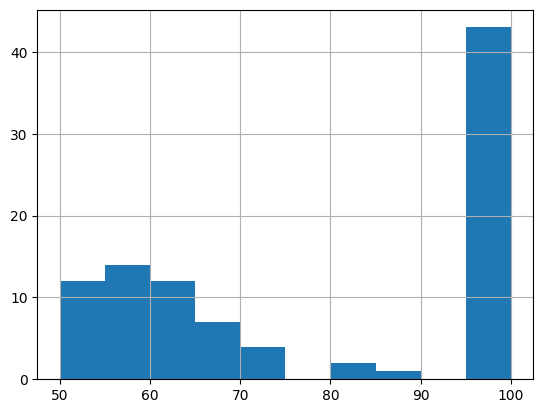

In [174]:
fuzzy_df['Fuzzy_scores'].hist()

- Keep companies where score > N

In [175]:
matched_df = fuzzy_df[fuzzy_df['Fuzzy_scores'] > 86].sort_values('Fuzzy_scores')

print("Number of matched companies:", len(matched_df))
matched_df.head(10)

Number of matched companies: 43


,CS685_list,Newsweek_list,Fuzzy_scores,nswk_idx
56,mcdonalds,mcdonald's,95,358
1,united parcel service,united parcel service,100,492
59,texas instruments,texas instruments,100,72
61,cisco,cisco systems,100,3
62,mastercard,mastercard,100,9
63,caterpillar,caterpillar,100,157
64,qualcomm,qualcomm,100,13
65,home depot,the home depot,100,167
66,ibm,ibm,100,67
68,t-mobile,t-mobile,100,217


In [123]:
nwdf[nwdf['Company'].str.contains('mart')]

,Company,HQ City,HQ State,Industry,Rank in Industry,Score Overall,Score Environmental Concerns,Score Social Concerns,Score Corporate Governance Concerns
Rank,,,,,,,,,


In [135]:
# fuzzy_df.head()
# fuzzy_df[fuzzy_df['Fuzzy_scores'] >= 100]
# fuzzy_df[fuzzy_df['Fuzzy_scores'] < 95].sort_values('Fuzzy_scores')

---

### Combine scores

In [181]:
df = matched_df.join(nwdf, how='inner', on='nswk_idx').join(odf, how='inner')

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 56 to 91
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CS685_list                           43 non-null     object 
 1   Newsweek_list                        43 non-null     object 
 2   Fuzzy_scores                         43 non-null     int64  
 3   nswk_idx                             43 non-null     int64  
 4   Rank                                 43 non-null     object 
 5   Company                              43 non-null     object 
 6   HQ City                              43 non-null     object 
 7   HQ State                             43 non-null     object 
 8   Industry                             43 non-null     object 
 9   Rank in Industry                     43 non-null     object 
 10  Score Overall                        43 non-null     float64
 11  Score Environmental Concerns         4

In [184]:
# relevant columns
r_cols = ['Company name', 'Fuzzy_scores', 'Score Overall', 'Score Environmental Concerns', 'score', 'total_scope3',]

In [186]:
df = df[r_cols]

In [191]:
df.head()

,Company name,Fuzzy_scores,Score Overall,Score Environmental Concerns,score,total_scope3
56,McDonalds,95,73.42,76.35,134.20,284
1,United Parcel Service,100,69.52,54.60,0.72,0
59,Texas Instruments,100,82.46,78.99,145.56,116
61,Cisco,100,90.03,98.60,150.00,160
62,Mastercard,100,87.65,98.39,150.52,152


- Normalize scores

In [197]:
dfn = df.copy()

In [195]:
def normalize(series):
    norm = lambda x: (x - series.mean()) / series.std()
    return series.apply(norm)

In [202]:
# relevant score columns + normalized column names
r_scores = [('Score Overall', 'NWK_score_total'), ('Score Environmental Concerns', 'NWK_score_ESG'), ('score', 'CS_score_total'), ('total_scope3', 'CS_score_S3')]

In [204]:
for s, n in r_scores:
    dfn[n] = normalize(dfn[s])

In [229]:
dfn = dfn.sort_values(by=['NWK_score_total', 'CS_score_total']).reset_index(drop=True)

In [230]:
dfn.head()

,Company name,Fuzzy_scores,Score Overall,Score Environmental Concerns,score,total_scope3,NWK_score_total,NWK_score_ESG,CS_score_total,CS_score_S3
0,Union Pacific,100,67.21,74.58,40.12,40,-1.951391,-0.957357,-1.058705,-1.007283
1,ConocoPhillips,100,68.53,75.98,180.16,272,-1.740112,-0.811510,0.501907,0.943155
2,United Parcel Service,100,69.52,54.60,0.72,0,-1.581652,-3.038803,-1.497781,-1.343566
3,Honeywell,100,69.55,74.96,94.12,72,-1.576851,-0.917770,-0.456927,-0.738257
4,General Electric,100,70.16,62.93,280.96,228,-1.479214,-2.171013,1.625227,0.573244


,NWK_score_total,CS_score_total
NWK_score_total,1.000000,0.385409
CS_score_total,0.385409,1.000000


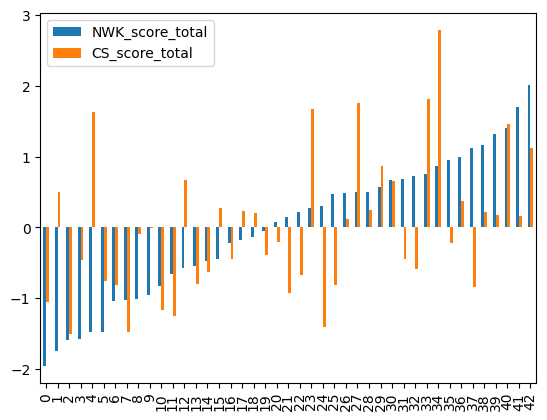

In [231]:
dfn[['NWK_score_total', 'CS_score_total']].plot(kind='bar')
dfn[['NWK_score_total', 'CS_score_total']].corr()

,NWK_score_ESG,CS_score_S3
NWK_score_ESG,1.000000,0.269736
CS_score_S3,0.269736,1.000000


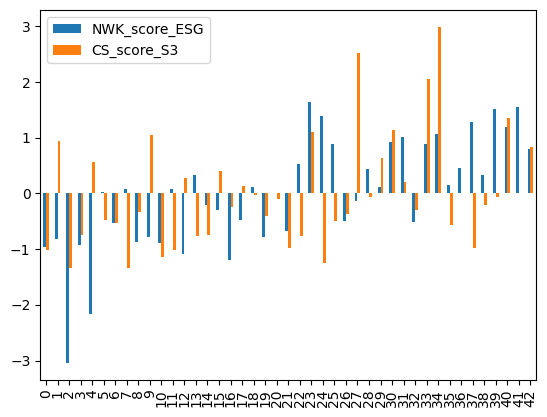

In [232]:
dfn[['NWK_score_ESG', 'CS_score_S3']].plot(kind='bar')
dfn[['NWK_score_ESG', 'CS_score_S3']].corr()

In [157]:
# nwdf.loc[matched_df['nswk_idx']]

In [155]:
# df.head()

### Analysis

<Axes: xlabel='Rank'>

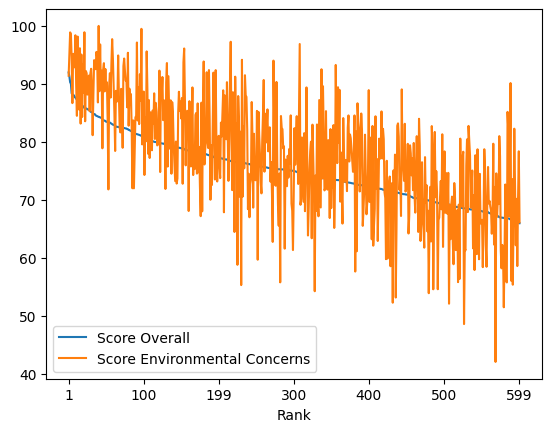

In [136]:
df = nwdf[['Company', 'Score Overall', 'Score Environmental Concerns']]
df.plot()

Some notable companies were not included in the Newsweek list, including such bellweathers as Amazon, Walmart, Tesla, Pepsi, and Nike. 